In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

# Setup

In [10]:
df = pd.read_csv("data/results/time_data.csv", sep=";")
df["time"] = pd.to_datetime(df["time"])

C:\Users\PC96-IONIC\AppData\Local\Temp\ipykernel_17200\3960761302.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df["time"] = pd.to_datetime(df["time"])


In [11]:
class FloodDataset(Dataset):
    def __init__(self, data, sequence_length, predict_ahead):
        self.data = data
        self.sequence_length = sequence_length
        self.predict_ahead = predict_ahead

    def __len__(self):
        # Ensure length is non-negative
        return max(0, len(self.data) - self.sequence_length - self.predict_ahead + 1)

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self):
            raise IndexError(f"Index {idx} is out of bounds for dataset of size {len(self)}")
        
        # Input sequence: rain_gauge_1 and rain_gauge_2 for the past `sequence_length` time steps
        x = self.data[idx:idx+self.sequence_length, :-1]
        
        y = self.data[idx+self.sequence_length + self.predict_ahead - 1, -1]
        
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        
        return x, y

In [12]:
class FloodLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(FloodLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

In [13]:
def collate_fn(batch):
    # Separate inputs and labels
    inputs, labels = zip(*batch)
    
    # Pad the input sequences to the same length
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    
    # Stack the labels into a single tensor
    labels = torch.stack(labels)
    
    return inputs_padded, labels

In [14]:
def print_class_distribution(data, dataset_name):
    class_counts = np.unique(data[:, -1], return_counts=True)
    print(f"Class distribution in {dataset_name}:")
    for class_label, count in zip(class_counts[0], class_counts[1]):
        print(f"Class {int(class_label)}: {count} examples")

In [31]:
def evalute_model(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.squeeze().cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Flood", "Flood"], yticklabels=["No Flood", "Flood"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    class_report = classification_report(all_labels, all_predictions, target_names=["No Flood", "Flood"])
    print("\nClassification Report:\n", class_report)

In [32]:
def train_evaluate_lstm(train_dataloader, test_dataloader, hidden_size, num_layers, criterion=nn.BCELoss()):
    input_size = 2  # rain_gauge_1 and rain_gauge_2
    output_size = 1  # flood_boolean (binary)
    model = FloodLSTM(input_size, hidden_size, num_layers, output_size)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 50
    for _ in range(num_epochs):
        for _, (inputs, labels) in enumerate(train_dataloader):
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


    evalute_model(model, test_dataloader)

    return model

In [33]:
data = df[["812A", "833A", "flood"]].values

sequence_length = 6
predict_ahead = 1

X = data[:, :-1]  # Features: rain_gauge_1, rain_gauge_2
y = data[:, -1]   # Labels: flood_boolean

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

# Combine the scaled features and labels back into a single array
data_scaled = np.hstack([X_scaled, y.reshape(-1, 1)])

train_size = int(len(data_scaled) * 0.70)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

print_class_distribution(train_data, "training data")

Class distribution in training data:
Class 0: 8656 examples
Class 1: 416 examples


# Oversample

## Tratamento dos dados

In [34]:
def oversample_minority_class(data):
    # Separate minority and majority classes
    minority_class = data[data[:, -1] == 1]
    majority_class = data[data[:, -1] == 0]
    
    # Oversample minority class
    oversample_factor = len(majority_class) // len(minority_class)
    oversampled_minority = np.repeat(minority_class, repeats=oversample_factor, axis=0)
    
    # Combine the datasets
    balanced_data = np.vstack([majority_class, oversampled_minority])
    
    # Shuffle the dataset
    np.random.shuffle(balanced_data)
    
    return balanced_data

def oversample_minority_class_smote(data):
    # Separate features (X) and labels (y)
    X = data[:, :-1]  # All columns except the last one
    y = data[:, -1]   # Last column (labels)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Combine the resampled features and labels
    balanced_data = np.hstack([X_resampled, y_resampled.reshape(-1, 1)])

    return balanced_data

In [35]:
train_data_oversampled = oversample_minority_class_smote(train_data)

print_class_distribution(train_data_oversampled, "oversampled training data")

Class distribution in oversampled training data:
Class 0: 8656 examples
Class 1: 8656 examples


In [36]:
print("Training data shape:", train_data_oversampled.shape)
print("Test data shape:", test_data.shape)

train_dataset_oversampled = FloodDataset(train_data_oversampled, sequence_length, predict_ahead)
test_dataset_oversampled = FloodDataset(test_data, sequence_length, predict_ahead)

print("Number of training samples:", len(train_dataset_oversampled))
print("Number of testing samples:", len(test_dataset_oversampled))

batch_size = 32

train_dataloader_oversampled = DataLoader(train_dataset_oversampled, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader_oversampled = DataLoader(test_dataset_oversampled, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Training data shape: (17312, 3)
Test data shape: (3888, 3)
Number of training samples: 17306
Number of testing samples: 3882


## Camadas: 1

### Neurônios: 32

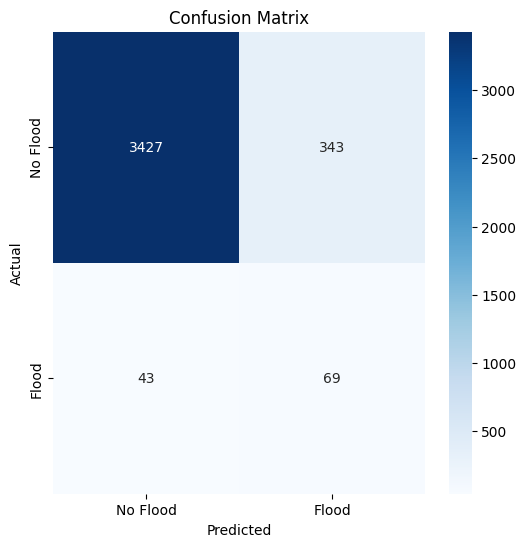


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.91      0.95      3770
       Flood       0.17      0.62      0.26       112

    accuracy                           0.90      3882
   macro avg       0.58      0.76      0.61      3882
weighted avg       0.96      0.90      0.93      3882



FloodLSTM(
  (lstm): LSTM(2, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [37]:
neurons = 32
layers = 1

train_evaluate_lstm(train_dataloader_oversampled, 
                    test_dataloader_oversampled, 
                    neurons, 
                    layers)

### Neurônios: 64

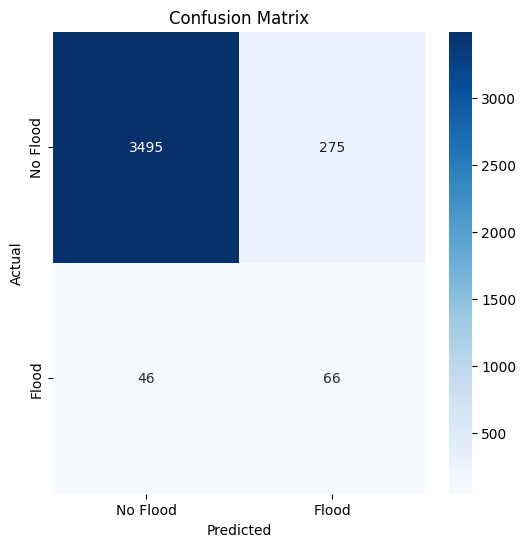


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.93      0.96      3770
       Flood       0.19      0.59      0.29       112

    accuracy                           0.92      3882
   macro avg       0.59      0.76      0.62      3882
weighted avg       0.96      0.92      0.94      3882



In [78]:
neurons = 64
layers = 1

train_evaluate_lstm(train_dataloader_oversampled, 
                    test_dataloader_oversampled, 
                    neurons, 
                    layers)

### Neurônios: 128

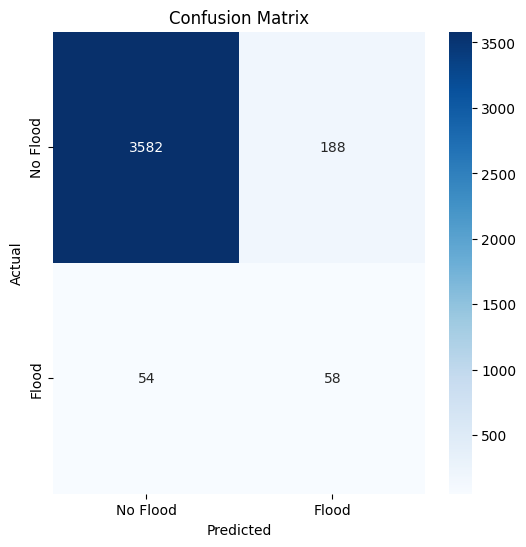


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.95      0.97      3770
       Flood       0.24      0.52      0.32       112

    accuracy                           0.94      3882
   macro avg       0.61      0.73      0.65      3882
weighted avg       0.96      0.94      0.95      3882



In [22]:
neurons = 128
layers = 1

train_evaluate_lstm(train_dataloader_oversampled, 
                    test_dataloader_oversampled, 
                    neurons, 
                    layers)

## Camadas: 2

### Neurônios: 32

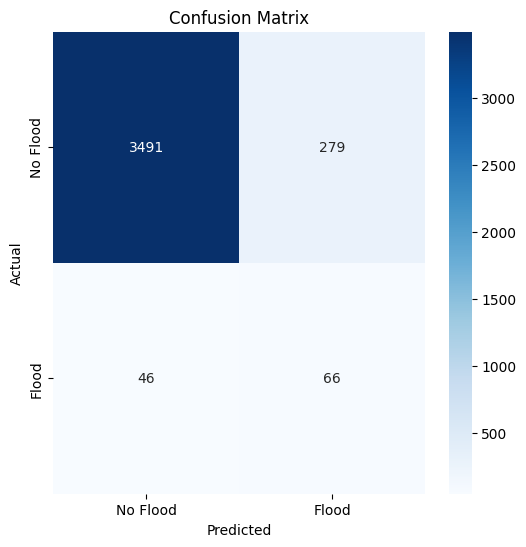


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.93      0.96      3770
       Flood       0.19      0.59      0.29       112

    accuracy                           0.92      3882
   macro avg       0.59      0.76      0.62      3882
weighted avg       0.96      0.92      0.94      3882



In [23]:
neurons = 32
layers = 2

train_evaluate_lstm(train_dataloader_oversampled,
                    test_dataloader_oversampled,
                    neurons,
                    layers)

### Neurônios: 64

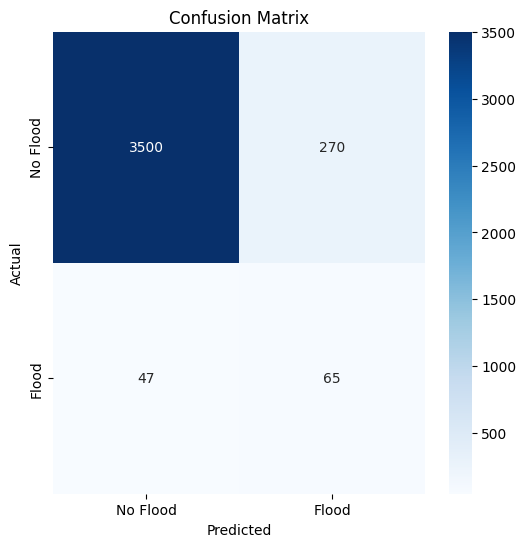


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.93      0.96      3770
       Flood       0.19      0.58      0.29       112

    accuracy                           0.92      3882
   macro avg       0.59      0.75      0.62      3882
weighted avg       0.96      0.92      0.94      3882



In [24]:
neurons = 64
layers = 2

train_evaluate_lstm(train_dataloader_oversampled, 
                    test_dataloader_oversampled, 
                    neurons, 
                    layers)

### Neurônios: 128

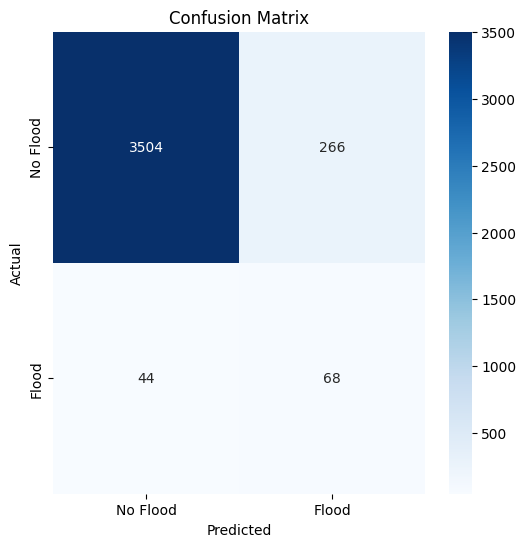


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.93      0.96      3770
       Flood       0.20      0.61      0.30       112

    accuracy                           0.92      3882
   macro avg       0.60      0.77      0.63      3882
weighted avg       0.96      0.92      0.94      3882



In [25]:
neurons = 128
layers = 2

train_evaluate_lstm(train_dataloader_oversampled, 
                    test_dataloader_oversampled, 
                    neurons, 
                    layers)

# Treinamento com pesos nas classes

Ao invés de utilizar oversampling, esse teste adiciona peso as classes durante o treinamento do modelo.

## Tratamento dos dados

In [62]:
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

train_dataset = FloodDataset(train_data, sequence_length, predict_ahead)
test_dataset = FloodDataset(test_data, sequence_length, predict_ahead)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Training data shape: (9072, 3)
Test data shape: (3888, 3)
Number of training samples: 9066
Number of testing samples: 3882


In [63]:
train_df = df[:train_size]

num_negatives = len(train_df[train_df["flood"] == 0])
num_positives = len(train_df[train_df["flood"] == 1])

pos_weight = torch.tensor([num_negatives/num_positives])
weighted_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

## Camadas: 1

### Neurônios: 32

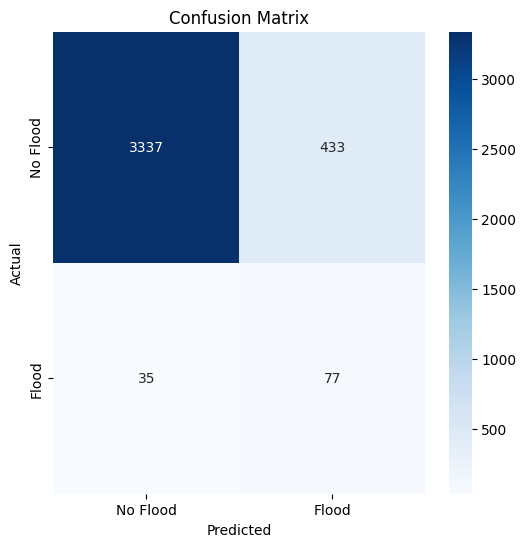


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.89      0.93      3770
       Flood       0.15      0.69      0.25       112

    accuracy                           0.88      3882
   macro avg       0.57      0.79      0.59      3882
weighted avg       0.97      0.88      0.91      3882



In [64]:
neurons = 32
layers = 1

train_evaluate_lstm(train_dataloader,
                    test_dataloader,
                    neurons,
                    layers,
                    weighted_criterion)

### Neurônios: 64

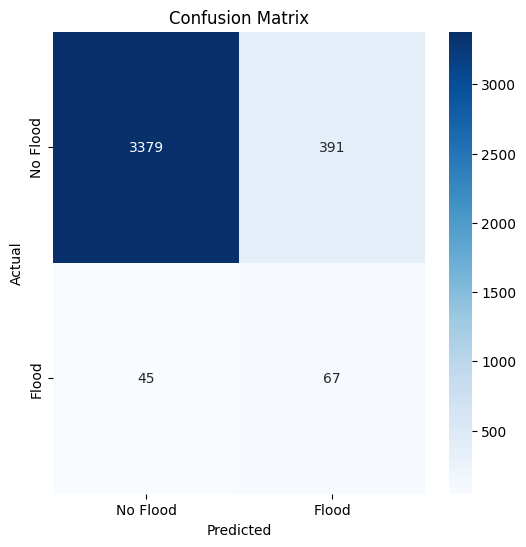


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.90      0.94      3770
       Flood       0.15      0.60      0.24       112

    accuracy                           0.89      3882
   macro avg       0.57      0.75      0.59      3882
weighted avg       0.96      0.89      0.92      3882



In [49]:
neurons = 64
layers = 1

train_evaluate_lstm(train_dataloader,
                    test_dataloader,
                    neurons,
                    layers,
                    weighted_criterion)

### Neurônios: 128

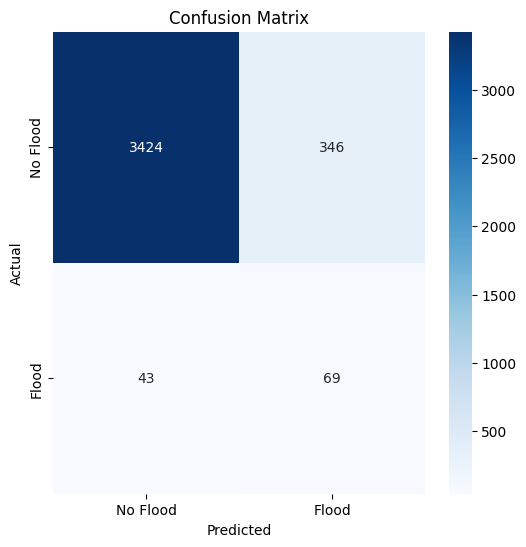


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.91      0.95      3770
       Flood       0.17      0.62      0.26       112

    accuracy                           0.90      3882
   macro avg       0.58      0.76      0.60      3882
weighted avg       0.96      0.90      0.93      3882



In [50]:
neurons = 128
layers = 1

train_evaluate_lstm(train_dataloader,
                    test_dataloader,
                    neurons,
                    layers,
                    weighted_criterion)

## Camadas: 2

### Neurônios: 32

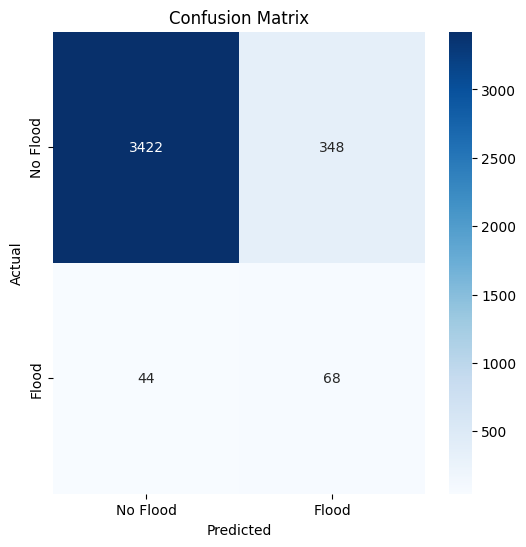


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.91      0.95      3770
       Flood       0.16      0.61      0.26       112

    accuracy                           0.90      3882
   macro avg       0.58      0.76      0.60      3882
weighted avg       0.96      0.90      0.93      3882



In [46]:
neurons = 32
layers = 2

train_evaluate_lstm(train_dataloader,
                    test_dataloader,
                    neurons,
                    layers,
                    weighted_criterion)

### Neurônios: 64

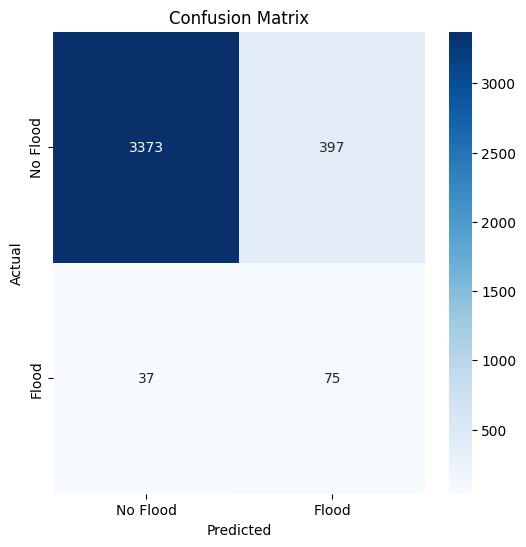


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.89      0.94      3770
       Flood       0.16      0.67      0.26       112

    accuracy                           0.89      3882
   macro avg       0.57      0.78      0.60      3882
weighted avg       0.97      0.89      0.92      3882



In [45]:
neurons = 64
layers = 2

train_evaluate_lstm(train_dataloader,
                    test_dataloader,
                    neurons,
                    layers,
                    weighted_criterion)

### Neurônios: 128

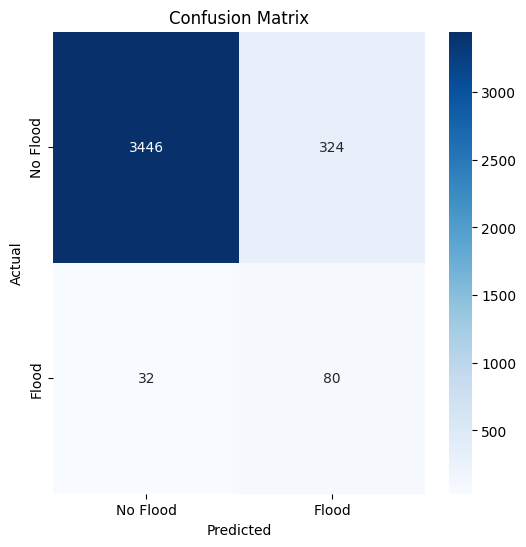


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.91      0.95      3770
       Flood       0.20      0.71      0.31       112

    accuracy                           0.91      3882
   macro avg       0.59      0.81      0.63      3882
weighted avg       0.97      0.91      0.93      3882



In [47]:
neurons = 128
layers = 2

train_evaluate_lstm(train_dataloader,
                    test_dataloader,
                    neurons,
                    layers,
                    weighted_criterion)

## Prevendo janelas à frente

### 3 janelas

In [65]:
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

train_dataset = FloodDataset(train_data, sequence_length, 3)
test_dataset = FloodDataset(test_data, sequence_length, 3)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Training data shape: (9072, 3)
Test data shape: (3888, 3)
Number of training samples: 9064
Number of testing samples: 3880


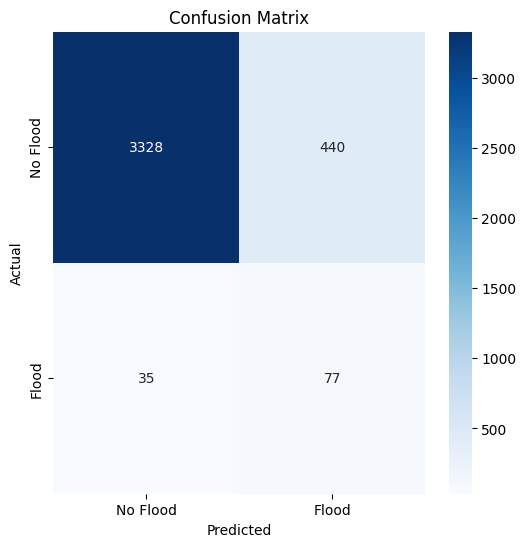


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.88      0.93      3768
       Flood       0.15      0.69      0.24       112

    accuracy                           0.88      3880
   macro avg       0.57      0.79      0.59      3880
weighted avg       0.97      0.88      0.91      3880



In [66]:
neurons = 128
layers = 2

train_evaluate_lstm(train_dataloader,
                    test_dataloader,
                    neurons,
                    layers,
                    weighted_criterion)

### 6 janelas

In [67]:
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

train_dataset = FloodDataset(train_data, sequence_length, 6)
test_dataset = FloodDataset(test_data, sequence_length, 6)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Training data shape: (9072, 3)
Test data shape: (3888, 3)
Number of training samples: 9061
Number of testing samples: 3877


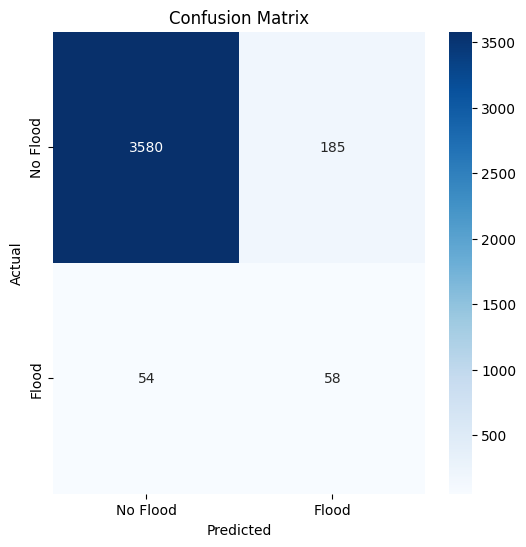


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.95      0.97      3765
       Flood       0.24      0.52      0.33       112

    accuracy                           0.94      3877
   macro avg       0.61      0.73      0.65      3877
weighted avg       0.96      0.94      0.95      3877



In [68]:
neurons = 128
layers = 2

train_evaluate_lstm(train_dataloader,
                    test_dataloader,
                    neurons,
                    layers,
                    weighted_criterion)

## Previsão usando tweets

In [39]:
def train_evaluate_lstm_with_tweets(train_dataloader, test_dataloader, hidden_size, num_layers, criterion=nn.BCELoss()):
    input_size = 3  # rain_gauge_1 and rain_gauge_2
    output_size = 1  # flood_boolean (binary)
    model = FloodLSTM(input_size, hidden_size, num_layers, output_size)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 50
    for _ in range(num_epochs):
        for _, (inputs, labels) in enumerate(train_dataloader):
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


    evalute_model(model, test_dataloader)

    return model

In [40]:
data = df[["812A", "833A", "tweets", "flood"]].values
sequence_length = 6
predict_ahead = 1

X = data[:, :-1]  # Features: rain_gauge_1, rain_gauge_2
y = data[:, -1]   # Labels: flood_boolean

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

# Combine the scaled features and labels back into a single array
data_scaled = np.hstack([X_scaled, y.reshape(-1, 1)])

train_size = int(len(data_scaled) * 0.70)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

print_class_distribution(train_data, "training data")

Class distribution in training data:
Class 0: 8656 examples
Class 1: 416 examples


In [41]:
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

train_dataset = FloodDataset(train_data, sequence_length, predict_ahead)
test_dataset = FloodDataset(test_data, sequence_length, predict_ahead)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Training data shape: (9072, 4)
Test data shape: (3888, 4)
Number of training samples: 9066
Number of testing samples: 3882


In [42]:
train_df = df[:train_size]

num_negatives = len(train_df[train_df["flood"] == 0])
num_positives = len(train_df[train_df["flood"] == 1])

pos_weight = torch.tensor([num_negatives/num_positives])
weighted_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

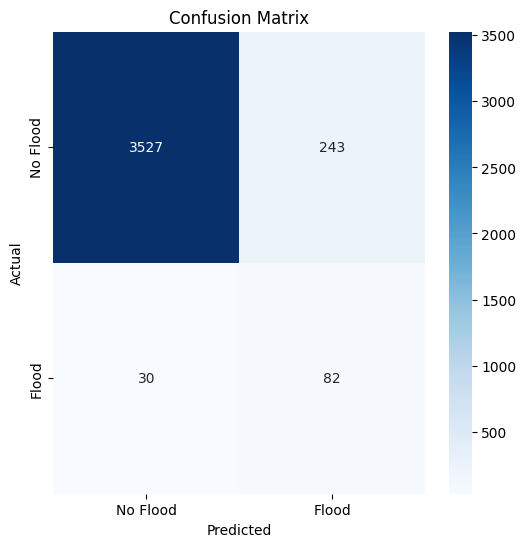


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.94      0.96      3770
       Flood       0.25      0.73      0.38       112

    accuracy                           0.93      3882
   macro avg       0.62      0.83      0.67      3882
weighted avg       0.97      0.93      0.95      3882



In [ ]:
neurons = 128
layers = 2

train_evaluate_lstm_with_tweets(train_dataloader,
                    test_dataloader,
                    neurons,
                    layers,
                    weighted_criterion)

## 3 janelas à frente

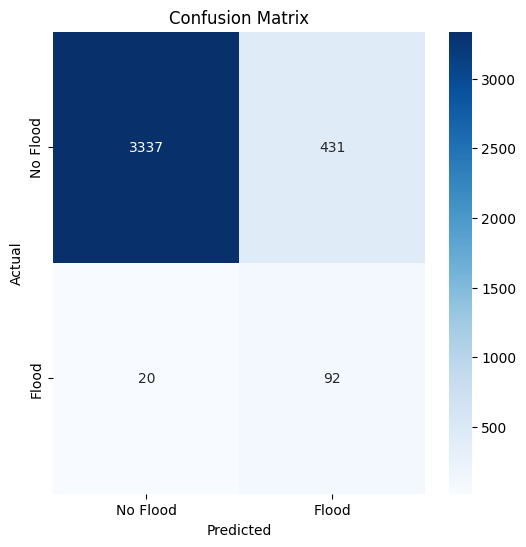


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.89      0.94      3768
       Flood       0.18      0.82      0.29       112

    accuracy                           0.88      3880
   macro avg       0.58      0.85      0.61      3880
weighted avg       0.97      0.88      0.92      3880



In [56]:
train_dataset = FloodDataset(train_data, 6, 3)
test_dataset = FloodDataset(test_data, 6, 3)

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

neurons = 128
layers = 2

_ = train_evaluate_lstm_with_tweets(train_dataloader,
                    test_dataloader,
                    neurons,
                    layers,
                    weighted_criterion)

## 6 janelas à frente

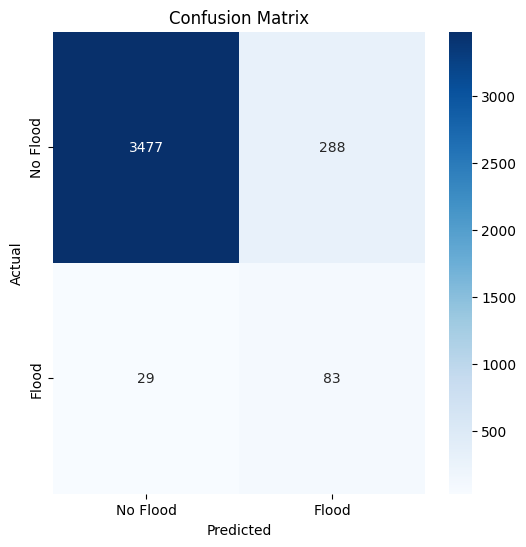


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.92      0.96      3765
       Flood       0.22      0.74      0.34       112

    accuracy                           0.92      3877
   macro avg       0.61      0.83      0.65      3877
weighted avg       0.97      0.92      0.94      3877



In [57]:
train_dataset = FloodDataset(train_data, 6, 6)
test_dataset = FloodDataset(test_data, 6, 6)

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

neurons = 128
layers = 2

_ = train_evaluate_lstm_with_tweets(train_dataloader,
                    test_dataloader,
                    neurons,
                    layers,
                    weighted_criterion)